In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
mice_eeg1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('EEG_mouse_data_2.csv')
mice_eeg = pd.concat([mice_eeg1, mice_eeg2])
mice_eeg

NameError: name 'pd' is not defined

In [ ]:
mice25features = mice_eeg.iloc[:,:26]
mice25features

,state,amplitude_around_1_Hertz,amplitude_around_2_Hertz,amplitude_around_3_Hertz,amplitude_around_4_Hertz,amplitude_around_5_Hertz,amplitude_around_6_Hertz,amplitude_around_7_Hertz,amplitude_around_8_Hertz,amplitude_around_9_Hertz,...,amplitude_around_16_Hertz,amplitude_around_17_Hertz,amplitude_around_18_Hertz,amplitude_around_19_Hertz,amplitude_around_20_Hertz,amplitude_around_21_Hertz,amplitude_around_22_Hertz,amplitude_around_23_Hertz,amplitude_around_24_Hertz,amplitude_around_25_Hertz
0,n,0.000009,0.000014,0.000013,0.000014,0.000023,0.000009,0.000019,0.000011,0.000016,...,1.121431e-06,9.572615e-07,7.912338e-07,2.075210e-06,2.125421e-06,9.183682e-07,1.442768e-06,1.315617e-06,1.882535e-06,3.555321e-07
1,n,0.000010,0.000010,0.000011,0.000015,0.000022,0.000017,0.000027,0.000011,0.000011,...,1.214325e-06,2.456797e-06,2.102875e-06,3.754975e-07,1.144381e-06,1.869306e-06,9.546215e-07,8.958666e-07,2.865039e-07,8.280935e-07
2,n,0.000011,0.000077,0.000034,0.000019,0.000013,0.000006,0.000010,0.000004,0.000006,...,2.251707e-06,3.322518e-06,1.112426e-06,8.238182e-07,8.392117e-07,6.979253e-07,4.631708e-07,3.179654e-07,3.833318e-07,2.466324e-07
3,w,0.000003,0.000031,0.000044,0.000016,0.000007,0.000006,0.000005,0.000007,0.000006,...,2.197342e-06,8.276670e-07,6.019235e-07,3.639088e-07,3.230235e-07,4.536860e-07,5.793950e-07,2.854656e-07,9.187695e-07,5.579241e-07
4,w,0.000010,0.000011,0.000012,0.000017,0.000020,0.000018,0.000014,0.000025,0.000018,...,3.330912e-06,3.003597e-06,3.560957e-06,1.856221e-06,8.180798e-07,1.657310e-06,2.038410e-06,9.678699e-07,6.374025e-07,8.643028e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20600,w,0.000025,0.000007,0.000007,0.000003,0.000005,0.000002,0.000005,0.000010,0.000013,...,7.605994e-07,5.857975e-07,2.008976e-06,1.047500e-06,8.361965e-07,1.187530e-06,1.362517e-06,1.155722e-06,4.674335e-07,4.710592e-07
20601,w,0.000017,0.000038,0.000015,0.000011,0.000019,0.000006,0.000010,0.000012,0.000009,...,4.660933e-07,4.797065e-07,1.377159e-06,1.549855e-06,2.014634e-06,1.006481e-06,1.255027e-06,7.684788e-07,1.131635e-06,1.080890e-06
20602,w,0.000016,0.000028,0.000031,0.000011,0.000019,0.000001,0.000015,0.000002,0.000007,...,9.727383e-07,5.698932e-07,8.794702e-07,9.412227e-07,7.479130e-07,1.173636e-07,8.319340e-07,1.222192e-07,1.277335e-07,2.256663e-07
20603,w,0.000013,0.000014,0.000020,0.000018,0.000007,0.000013,0.000009,0.000018,0.000005,...,7.172008e-07,1.828871e-06,5.327440e-07,5.149679e-07,6.310218e-07,4.164332e-07,3.309523e-07,8.170078e-07,6.630207e-07,9.615590e-07


In [1]:
# Instanciez un objet StandardScaler
scaler = StandardScaler()


# Normalisez les données
normalized_data = scaler.fit_transform(mice25features.iloc[:,1:26])

# Créez un nouveau DataFrame à partir des données normalisées
normalized_df = pd.DataFrame(normalized_data, columns=mice25features.iloc[:,1:26].columns)

normalize_pd = pd.concat([mice25features.state, normalized_df], axis=1)
print("Données normalisées :")
print(normalized_df)

NameError: name 'StandardScaler' is not defined

In [26]:
#Création des 3 folds
import numpy as np
import matplotlib.pyplot as pl
import keras
from keras import layers
from sklearn.model_selection import KFold

input_data = mice25features.drop(columns=['state']).values  # Caractéristiques (amplitudes des signaux)
output = mice25features['state'].values  # Étiquettes (états de sommeil)
output_data = np.where(np.array(output) == 'w', 1, -1)

input_data_train = []
input_data_test = []
output_data_train = []
output_data_test = []

pl.clf()

keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

for train_index, test_index in kf.split(input_data):
    input_data_train, input_data_test = input_data[train_index], input_data[test_index]  # Données d'entraînement et de test
    output_data_train, output_data_test = output_data[train_index], output_data[test_index]  # Étiquettes d'entraînement et de test

<Figure size 640x480 with 0 Axes>

In [27]:
#Création du model
def create_model():
  # 2 inputs
  # 2 hidden nodes
  # 1 output

  mlp = keras.Sequential([
      layers.Input(25),
      layers.Dense(32, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(1, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()

In [37]:
# Normaliser les données
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data_train)
input_data

array([[-0.176044  , -0.32745009, -0.23171737, ...,  0.25274356,
        -0.83657039,  0.34495311],
       [-0.13722858,  3.69471999,  1.37961421, ..., -0.80554256,
        -0.64594716, -0.89018617],
       [-0.42789313,  0.94947659,  2.05586292, ..., -0.865058  ,
         0.40815971, -0.22894052],
       ...,
       [-0.0060036 ,  0.02979516, -0.27276182, ..., -0.21599101,
        -0.07249894, -1.23816658],
       [ 0.3903583 , -0.4678641 , -0.52454839, ...,  0.7286054 ,
        -0.48037751, -0.41345899],
       [-0.05875411, -0.08623857,  0.37122744, ...,  0.1083329 ,
        -0.09532837,  0.6284604 ]])

In [38]:
# Normaliser les données
# scaler = StandardScaler()
# input_data = scaler.fit_transform(input_data_train)

history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kf.split(input_data)):
  # We need to create a new model everytime otherwise fit will continue previous training
  mlp = create_model()

  history = mlp.fit(
      x=input_data[train_index], y=output_data[train_index],
      validation_data=(input_data[test_index], output_data[test_index]),
      epochs=10
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/10
568/568 [==============================] - 2s 3ms/step - loss: 1.3360 - val_loss: 1.4025
Epoch 2/10
568/568 [==============================] - 2s 4ms/step - loss: 1.3886 - val_loss: 1.4029
Epoch 3/10
568/568 [==============================] - 2s 3ms/step - loss: 1.3882 - val_loss: 1.3999
Epoch 4/10
568/568 [==============================] - 1s 2ms/step - loss: 1.3895 - val_loss: 1.3742
Epoch 5/10
568/568 [==============================] - 1s 3ms/step - loss: 1.3816 - val_loss: 1.3964
Epoch 6/10
568/568 [==============================] - 2s 3ms/step - loss: 1.3822 - val_loss: 1.3907
Epoch 7/10
568/568 [==============================] - 1s 2ms/step - loss: 1.4081 - val_loss: 1.4136
Epoch 8/10
568/568 [==============================] - 1s 2ms/step - loss: 1.4011 - val_loss: 1.3986
Epoch 9/10
568/568 [==============================] - 1s 2ms/step - loss: 1.3963 - val_loss: 1.4018
Epoch 10/10
568/568 [==============================] - 2s 3ms/step - loss: 1.3974 - val_loss: 1.4034

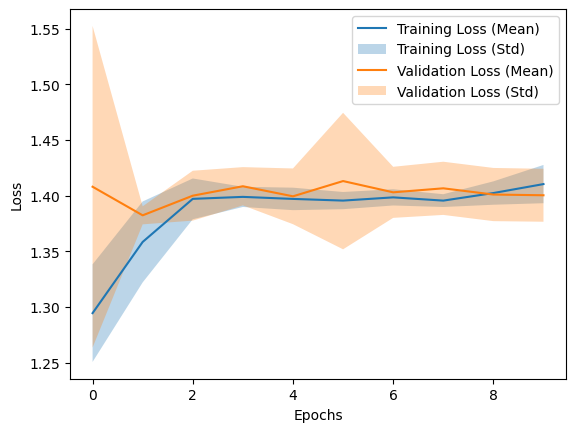

In [30]:
train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

In [31]:
for idx, model in enumerate(trained_mlp):
    # Plot model's output in the feature space
    input_x = np.arange(-1.2, 1.2, 0.1)
    input_y = np.arange(-1.2, 1.2, 0.1)
    input_x_matrix, input_y_matrix = np.meshgrid(input_x, input_y)
    inputs_xy = np.concatenate((input_x_matrix.flatten()[:,np.newaxis], input_y_matrix.flatten()[:,np.newaxis]), axis=1)

    output_values = model(inputs_xy)
    output_matrix = np.reshape(output_values, input_x_matrix.shape)

    pl.figure(figsize=(8,8))
    img = pl.imshow(np.flipud(output_matrix), interpolation='None', extent=(-1.2,1.2,-1.2,1.2), cmap="turbo")
    pl.colorbar(img, shrink=0.7)
    pl.scatter(input_data[:,0], input_data[:,1], c=[(['b', 'r'])[int(d>0)] for d in output_data], s=100, edgecolors='black')
    pl.title(f'MLP {idx+1} feature space output')
    pl.show()

ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 25), found shape=(576, 2)

In [ ]:
train_losses